Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [55]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [56]:
from glob import glob

In [57]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
# !unzip "/content/gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment.zip" -d 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [59]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [60]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [61]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [62]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(img_height,img_width),
            batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [63]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(img_height,img_width),
            batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [64]:
# List of all the classes of skin cancer
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


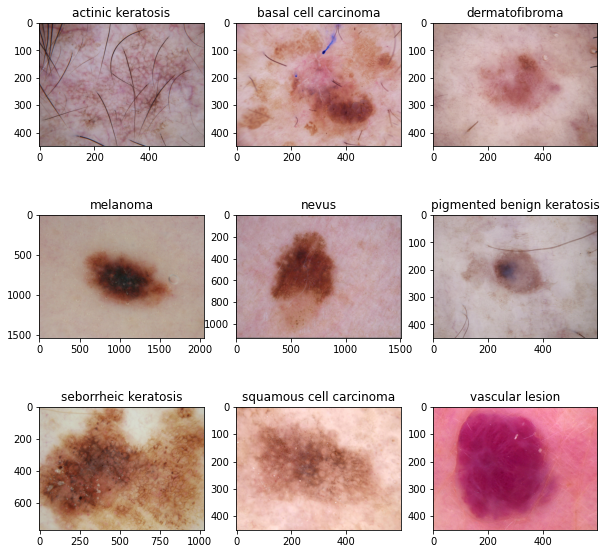

In [65]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [66]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [68]:

num_classes = len(class_names)

model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
        ])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [69]:
# choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [71]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 128ms/step - loss: 2.0693 - accuracy: 0.2109 - val_loss: 1.9306 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.7360 - accuracy: 0.3733 - val_loss: 1.5718 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.4712 - accuracy: 0.4771 - val_loss: 1.6471 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.3985 - accuracy: 0.5167 - val_loss: 1.4130 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.2723 - accuracy: 0.5597 - val_loss: 1.3682 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.1871 - accuracy: 0.5831 - val_loss: 1.4463 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.1401 - accuracy: 0.5988 - val_loss: 1.3628 - val_accuracy: 0.5481
Epoch 8/20


### Visualizing training results

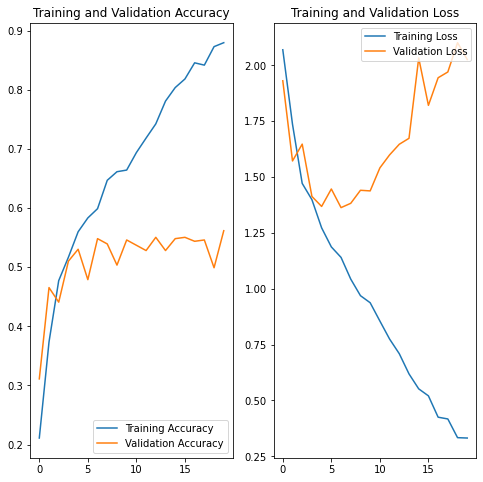

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings from above model

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.[link text](https://)

In [73]:
# analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])


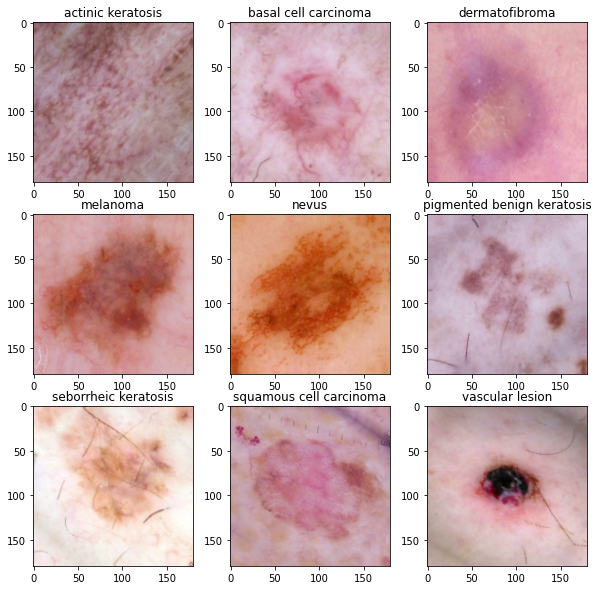

In [102]:
# visualize how augmentation strategy works for one instance of training image.

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        idx = np.where(labels[:]==i)[0]
        if(len(idx)>0):
            n=idx[0]
            plt.imshow(augmented_images[n].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis = "off"



### Create the model, compile and train the model


In [75]:
## use Dropout layer because there is an evidence of overfitting in findings


model = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
        ])

### Compiling the model

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [77]:
## train model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 71ms/step - loss: 2.0254 - accuracy: 0.2634 - val_loss: 1.7984 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.7647 - accuracy: 0.3694 - val_loss: 1.6597 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5901 - accuracy: 0.4319 - val_loss: 1.5324 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4658 - accuracy: 0.4888 - val_loss: 1.5554 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.4544 - accuracy: 0.4855 - val_loss: 1.4229 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4026 - accuracy: 0.5022 - val_loss: 1.6104 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3607 - accuracy: 0.5151 - val_loss: 1.3487 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

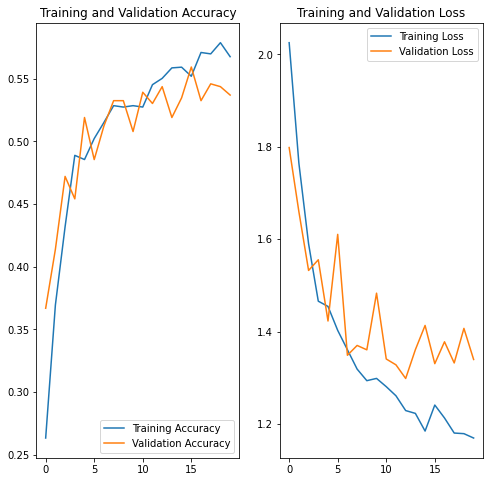

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



There has been a considerable improvement now as compared to the previous model as we can see from the train and validation accuracy that the model overfitting has been handled, but the model performance is not so good only around 56% train and validation accuracy around 53% 

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [79]:
# getting the exact paths of each image in train data folder
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list)

['gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', 'gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The Int

In [80]:
# getting the classes of each image dataset based on the folder name as per the skin cancer name
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
print(lesion_list)

['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

In [81]:
# creating a dictionary to prepare a dataframe
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

original_df.head()

,Path,Label
0,gdrive/My Drive/Colab Notebooks/CNN Skin Cance...,actinic keratosis
1,gdrive/My Drive/Colab Notebooks/CNN Skin Cance...,actinic keratosis
2,gdrive/My Drive/Colab Notebooks/CNN Skin Cance...,actinic keratosis
3,gdrive/My Drive/Colab Notebooks/CNN Skin Cance...,actinic keratosis
4,gdrive/My Drive/Colab Notebooks/CNN Skin Cance...,actinic keratosis


In [82]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

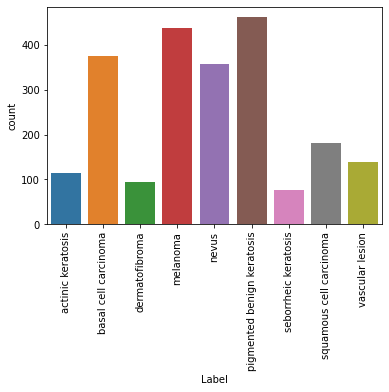

In [83]:
### Plotting graph to detect class imbalance¶

import seaborn as sns
# plt.figure(figsize=(8,8))
sns.countplot(x = 'Label', data=original_df)
plt.xticks(rotation=90)
plt.show()


Clearly from above graph we can see that there is a class imbalance issue and the images are not uniformly distributed

seborrheic keratosis class has the least number of samples, that is 77
pigmented benign keratosis, melanoma and basal cell carcinoma are the top 3 dominant classes wrt the sample count

To Rectify class imbalance we can use the Augmentor library to add more images to the existing samples which can help to resolve the class imbalance issue.

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [84]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [85]:
path_to_training_dataset='gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE9950C1990>: 100%|██████████| 500/500 [00:26<00:00, 19.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEA005C0B90>: 100%|██████████| 500/500 [00:27<00:00, 18.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE9950C5190>: 100%|██████████| 500/500 [00:27<00:00, 18.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE993969E90>: 100%|██████████| 500/500 [01:59<00:00,  4.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE993FBCE10>: 100%|██████████| 500/500 [01:33<00:00,  5.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE9952E76D0>: 100%|██████████| 500/500 [00:23<00:00, 21.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE9950CED50>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEA0F9BC650>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN Skin Cancer Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE993E16E50>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [86]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [87]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [88]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [89]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [90]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [91]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [92]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [93]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [94]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [95]:
# checking the class names
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [96]:
# Autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####  Create model (make sure to include normalization)

In [97]:
# creating the sequential model with rescaling, 3 conv, 3 maxpooling, 3 dropouts and 2 dense layers
model = Sequential([
    # rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer with softmax
  layers.Dense(num_classes,activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [98]:
# compiling the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [99]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 67s 105ms/step - loss: 2.0646 - accuracy: 0.2279 - val_loss: 1.6552 - val_accuracy: 0.3749
Epoch 2/30
169/169 [==============================] - 10s 61ms/step - loss: 1.5442 - accuracy: 0.4134 - val_loss: 1.4348 - val_accuracy: 0.4714
Epoch 3/30
169/169 [==============================] - 10s 61ms/step - loss: 1.3481 - accuracy: 0.5000 - val_loss: 1.2976 - val_accuracy: 0.5212
Epoch 4/30
169/169 [==============================] - 11s 63ms/step - loss: 1.2122 - accuracy: 0.5647 - val_loss: 1.1952 - val_accuracy: 0.5783
Epoch 5/30
169/169 [==============================] - 10s 61ms/step - loss: 1.1503 - accuracy: 0.5853 - val_loss: 1.1450 - val_accuracy: 0.6102
Epoch 6/30
169/169 [==============================] - 10s 61ms/step - loss: 1.0641 - accuracy: 0.6193 - val_loss: 1.1081 - val_accuracy: 0.5872
Epoch 7/30
169/169 [==============================] - 10s 62ms/step - loss: 0.9572 - accuracy: 0.6569 - val_loss: 1.0704 - val_accuracy

In [101]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

result = model.evaluate(test_ds)
dict(zip(model.metrics_names,result))

Found 118 files belonging to 9 classes.
4/4 [==============================] - 4s 26ms/step - loss: 6.3615 - accuracy: 0.4322


{'accuracy': 0.43220338225364685, 'loss': 6.361497402191162}

#### Visualize the model results

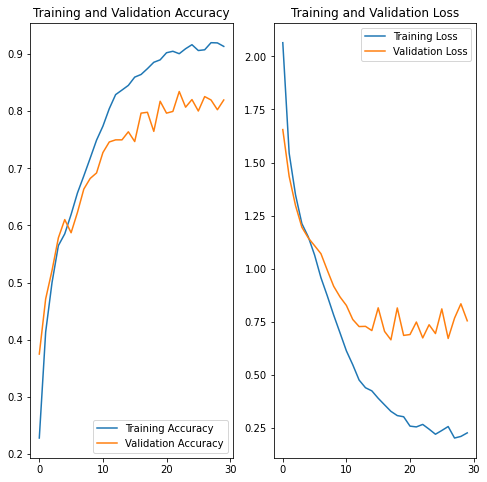

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Finally we could handle both overfitting and class imbalance issue and the model performance has increased considerably.
train accuracy is around 91% and validation accuracy around 82%
